In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import csv

# Baseline Experiments Results Visualization

In [12]:
# get all the CSV files from the parent directory
csv_files = [f for f in os.listdir("..") if f.endswith(".csv") and f.startswith("llm_query_results")]

print(csv_files)

# keep only the ones with gpt-5-mini
csv_files = [f for f in csv_files if 'gpt-5-mini' in f]

['llm_query_results--openrouter--simplePrompt--temp_0.2--top_p_0.1--openai-gpt-5-mini.csv', 'llm_query_results--openrouter--fullPrompt--temp_0.2--top_p_0.1--openai-gpt-5-mini.csv', 'llm_query_results--openrouter--fullPrompt--temp_0.2--top_p_0.1--openai-gpt-4.1-mini.csv']


In [13]:
# load each csv and concatenate them into a single dataframe

df = pd.DataFrame()

for f in csv_files:
    csv_df = pd.read_csv(os.path.join("..", f), quotechar='"', quoting=csv.QUOTE_NONNUMERIC)

    parts = f.split('--')
    provider = parts[1]
    temp = parts[3].split('_')[1]
    top_p = parts[4].split('_')[1]
    model_name = '--'.join(parts[5:]).replace('.csv', '')
    if 'openai' in model_name:
        model_name = model_name.replace('openai-', '')

    csv_df['source_file'] = f
    csv_df['provider'] = provider
    csv_df['generic_model_name'] = model_name

    df = pd.concat([df, csv_df], ignore_index=True)


In [14]:
print(df.columns)

print(f'DF Size: {df.shape}')

# print the df datatypes
# print(df.dtypes)

print(df.error.value_counts( dropna=False ))

Index(['source_code', 'combined_name', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'prompt_type', 'raw_flop_counts',
       'predicted_sp_flop_count', 'predicted_dp_flop_count',
       'predicted_sp_flop_count_explanation',
       'predicted_dp_flop_count_explanation', 'input_tokens', 'output_tokens',
       'total_cost', 'trial', 'modelName', 'nnz_flop_state', 'variant',
       'top_p', 'temp', 'totalQueryTime', 'error', 'source_file', 'provider',
       'generic_model_name'],
      dtype='object')
DF Size: (1265, 29)
error
NaN                                                                                                                                                                                                                                                                                             1238
QUERY TIMEOUT EVENT                                                         

## Adjust some of the columns

In [15]:
def parse_total_cost(x):
    if pd.isna(x):
        return -1.0
    cost_list = eval(x)
    assert len(cost_list) == 1, f"Expected a single cost value, got: {cost_list}"
    return cost_list[0]

df['total_cost'] = df['total_cost'].apply(parse_total_cost)
df['totalQueryTime'] = df['totalQueryTime'].astype(float)

def parse_error(x):
    if pd.isna(x):
        return "Success"
    elif "Invalid JSON" in str(x):
        return "Invalid\nJSON"
    elif "NoneType" in str(x):
        return "NoneType\nReturned"
    elif "TIMEOUT" in str(x):
        return "Query\nTimeout"
    return str(x)

df['error'] = df['error'].apply(parse_error)
df['has_nz_flops'] = df['nnz_flop_state'].apply(lambda x: 'No' if x == 'Zero SP + DP FLOP' else 'Yes')

print(df['error'].value_counts())
print(df[df['error'] != 'Success'])


# percent difference, we add a small epsilon to avoid division by zero
df['percent_diff_sp'] = 100*(df['predicted_sp_flop_count'] - df['empirical_sp_flop_count']) / (df['empirical_sp_flop_count'] + 1e-9)
df['percent_diff_dp'] = 100*(df['predicted_dp_flop_count'] - df['empirical_dp_flop_count']) / (df['empirical_dp_flop_count'] + 1e-9)

error
Success               1238
Query\nTimeout          20
NoneType\nReturned       6
Invalid\nJSON            1
Name: count, dtype: int64
     source_code                        combined_name kernel_name exec_args  \
24           NaN          (testSNAP-cuda, compute_yi)         NaN       NaN   
47           NaN                (chemv-cuda, kernel0)         NaN       NaN   
66           NaN       (attentionMultiHead-cuda, mha)         NaN       NaN   
154          NaN      (testSNAP-cuda, compute_deidrj)         NaN       NaN   
155          NaN          (testSNAP-cuda, compute_yi)         NaN       NaN   
182          NaN          (testSNAP-cuda, compute_yi)         NaN       NaN   
238          NaN      (testSNAP-cuda, compute_deidrj)         NaN       NaN   
239          NaN          (testSNAP-cuda, compute_yi)         NaN       NaN   
262          NaN                (chemv-cuda, kernel0)         NaN       NaN   
282          NaN                  (gmm-cuda, mstep_N)         NaN     

In [16]:
# now we want to plot the prediction accuracy vs. the ground truth for each generic_model_name and prompt_type

def plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='simple'):
    sub_df = df[(df['generic_model_name'] == model_name) & (df['prompt_type'] == prompt_type)]
    success_df = sub_df[(sub_df['error'] == 'Success')]

    print(f'Success DF Size: {success_df.shape}')
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

    max_sp_dp_flop = max(
        success_df['empirical_sp_flop_count'].max(),
        success_df['empirical_dp_flop_count'].max(),
        success_df['predicted_sp_flop_count'].max(),
        success_df['predicted_dp_flop_count'].max()
    )
    min_sp_dp_flop = min(
        success_df['empirical_sp_flop_count'].min(),
        success_df['empirical_dp_flop_count'].min(),
        success_df['predicted_sp_flop_count'].min(),
        success_df['predicted_dp_flop_count'].min()
    )

    # plot the x-y line on the plot
    ax.plot([min_sp_dp_flop, max_sp_dp_flop], [min_sp_dp_flop, max_sp_dp_flop], color='red', linestyle='--', alpha=0.5, label='perfect prediction')

    sns.scatterplot(x='empirical_sp_flop_count', y='predicted_sp_flop_count', data=success_df, label='SP FLOP', alpha=0.5, ax=ax, color='orange')
    sns.scatterplot(x='empirical_dp_flop_count', y='predicted_dp_flop_count', data=success_df, label='DP FLOP', alpha=0.5, ax=ax, color='blue')

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.set_title(f'Baseline: LLM-Predicted vs Actual FLOP Counts \n({model_name} -- {prompt_type} prompt)')

    ax.set_xlabel('Actual/Profiled FLOP Count')
    ax.set_ylabel('LLM-Predicted FLOP Count')
    # change x ticks font size
    ax.tick_params(axis='x', labelsize=6)
    # adjust the legend font size to be smaller
    ax.legend(fontsize=6)

    # put the legend outside the plot
    ax.legend(bbox_to_anchor=(1.01, 0.65), loc='upper left', fontsize=6)

    plt.tight_layout()
    plt.show()

    ##############################################
    # let's print the CDF of the percent differences for SP and DP FLOP counts

    nnz_sp_data = success_df['percent_diff_sp']
    nnz_dp_data = success_df['percent_diff_dp']

    # let's make a cdf plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)

    sns.ecdfplot(nnz_sp_data, label='SP FLOP', ax=ax, color='orange')
    sns.ecdfplot(nnz_dp_data, label='DP FLOP', ax=ax, color='blue')

    ax.set_xscale('symlog')
    #ax.set_yscale('log')
    ax.set_xlabel('Percent Difference (%)')
    ax.set_ylabel('Proportion of Data <= X')
    ax.legend()
    ax.set_title(f'CDF of Percent Differences \n({model_name} -- {prompt_type} prompt)')

    plt.tight_layout()
    plt.show()

    # what this plot tells us is that we care mostly about the <-1 % and >+1% predictions
    percents = [1, 5, 10, 50, 100]
    for perc in percents:
        num_sp_within_xpct = ((nnz_sp_data > -perc) & (nnz_sp_data < perc)).sum()
        num_sp_outside_xpct = ((nnz_sp_data <= -perc) | (nnz_sp_data >= perc)).sum()

        num_dp_within_xpct = ((nnz_dp_data > -perc) & (nnz_dp_data < perc)).sum()
        num_dp_outside_xpct = ((nnz_dp_data <= -perc) | (nnz_dp_data >= perc)).sum()

        total_sp = nnz_sp_data.shape[0]
        total_dp = nnz_dp_data.shape[0]

        print(f'SP FLOP: {num_sp_within_xpct} / {total_sp} ({100*num_sp_within_xpct/total_sp:.2f}%) within +/- {perc}%')
        print(f'SP FLOP: {num_sp_outside_xpct} / {total_sp} ({100*num_sp_outside_xpct/total_sp:.2f}%) outside +/- {perc}%')
        print(f'DP FLOP: {num_dp_within_xpct} / {total_dp} ({100*num_dp_within_xpct/total_dp:.2f}%) within +/- {perc}%')
        print(f'DP FLOP: {num_dp_outside_xpct} / {total_dp} ({100*num_dp_outside_xpct/total_dp:.2f}%) outside +/- {perc}%')
        print("\n")
    ##############################################


    # let's make histograms of the total_cost, totalQueryTime, and failure cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=200)

    sns.histplot(data=success_df, x='total_cost', hue='has_nz_flops', bins=50, ax=axs[0])
    axs[0].set_title('Query Cost Distribution')
    axs[0].set_xlabel('Query Cost ($ USD)')
    axs[0].set_ylabel('Frequency')
    axs[0].get_legend().set_title('Kernel has NZ FLOPs?')

    # rotate the x ticks for the query cost plot
    for label in axs[0].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')


    sns.histplot(data=success_df, x='totalQueryTime', hue='has_nz_flops', bins=50, ax=axs[1])
    axs[1].set_title('Total Query Time Distribution')
    axs[1].set_xlabel('Total Query Time (seconds)')
    axs[1].set_ylabel('Frequency')
    axs[1].get_legend().set_title('Kernel has NZ FLOPs?')

    #error_value_counts = df['error'].value_counts()
    sns.countplot(data=sub_df, x='error', ax=axs[2])
    axs[2].set_title('Failure Cases Distribution')
    axs[2].set_xlabel('Failure Cases')
    axs[2].set_ylabel('Frequency')

    # add countplot values on top of the bars
    for p in axs[2].patches:
        axs[2].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

    return


Success DF Size: (621, 32)


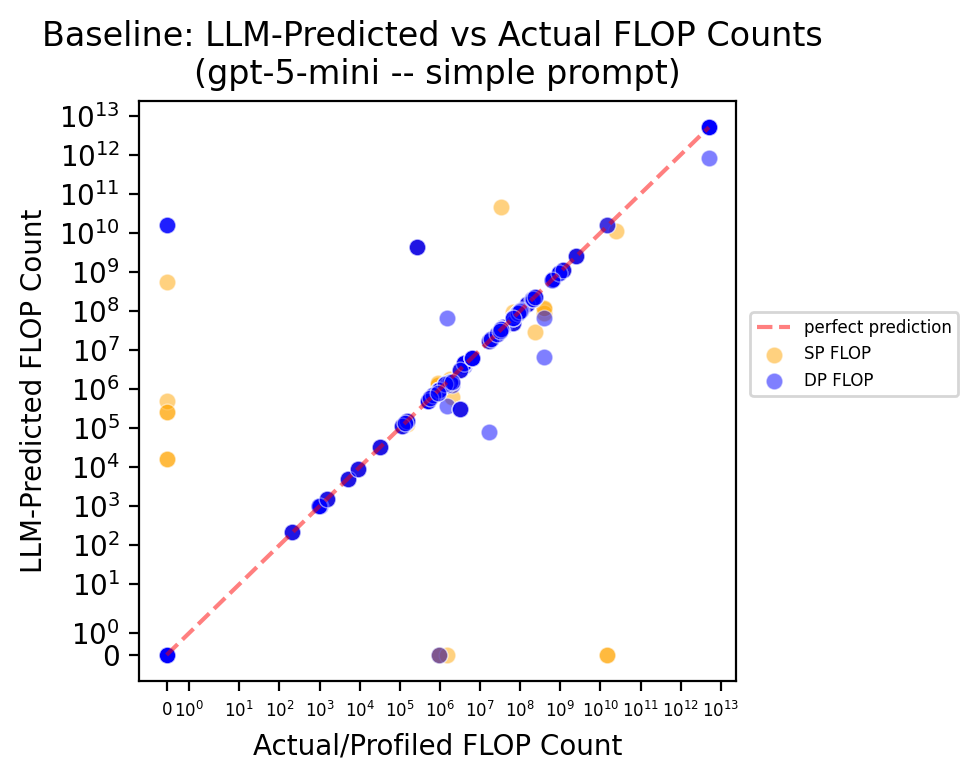

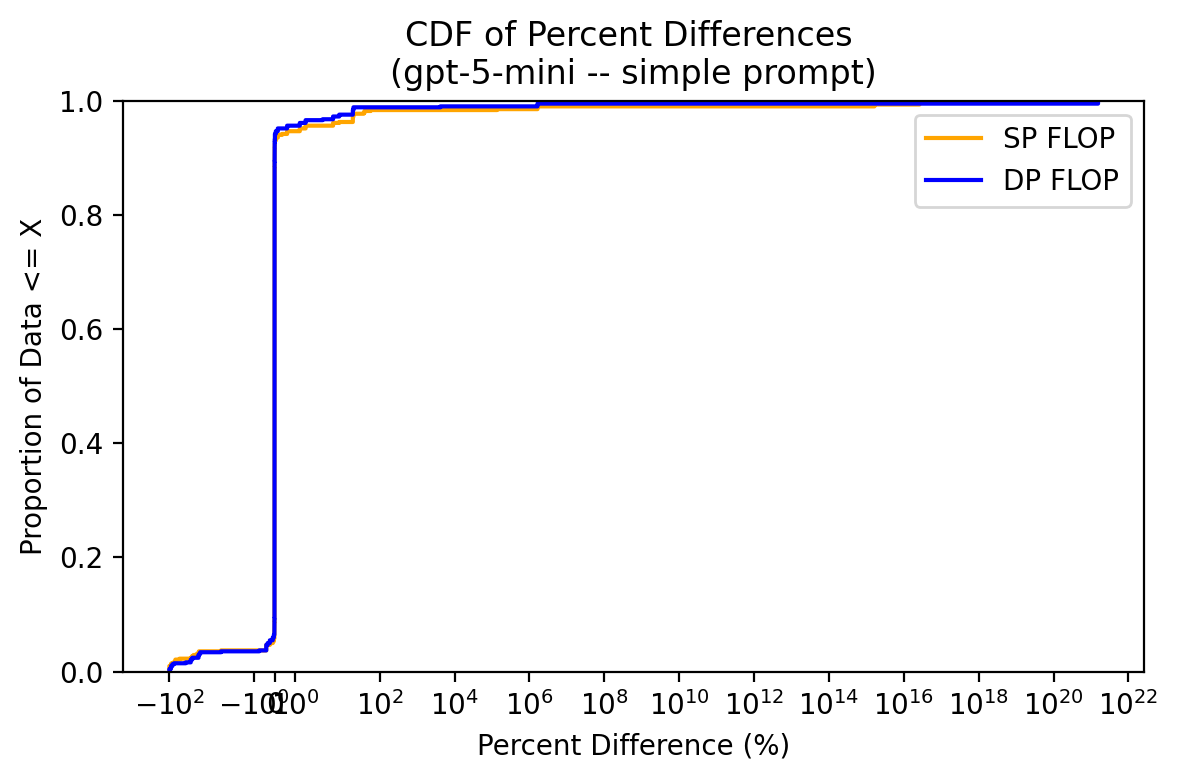

SP FLOP: 565 / 621 (90.98%) within +/- 1%
SP FLOP: 56 / 621 (9.02%) outside +/- 1%
DP FLOP: 572 / 621 (92.11%) within +/- 1%
DP FLOP: 49 / 621 (7.89%) outside +/- 1%


SP FLOP: 572 / 621 (92.11%) within +/- 5%
SP FLOP: 49 / 621 (7.89%) outside +/- 5%
DP FLOP: 580 / 621 (93.40%) within +/- 5%
DP FLOP: 41 / 621 (6.60%) outside +/- 5%


SP FLOP: 576 / 621 (92.75%) within +/- 10%
SP FLOP: 45 / 621 (7.25%) outside +/- 10%
DP FLOP: 585 / 621 (94.20%) within +/- 10%
DP FLOP: 36 / 621 (5.80%) outside +/- 10%


SP FLOP: 596 / 621 (95.97%) within +/- 50%
SP FLOP: 25 / 621 (4.03%) outside +/- 50%
DP FLOP: 605 / 621 (97.42%) within +/- 50%
DP FLOP: 16 / 621 (2.58%) outside +/- 50%


SP FLOP: 609 / 621 (98.07%) within +/- 100%
SP FLOP: 12 / 621 (1.93%) outside +/- 100%
DP FLOP: 614 / 621 (98.87%) within +/- 100%
DP FLOP: 7 / 621 (1.13%) outside +/- 100%




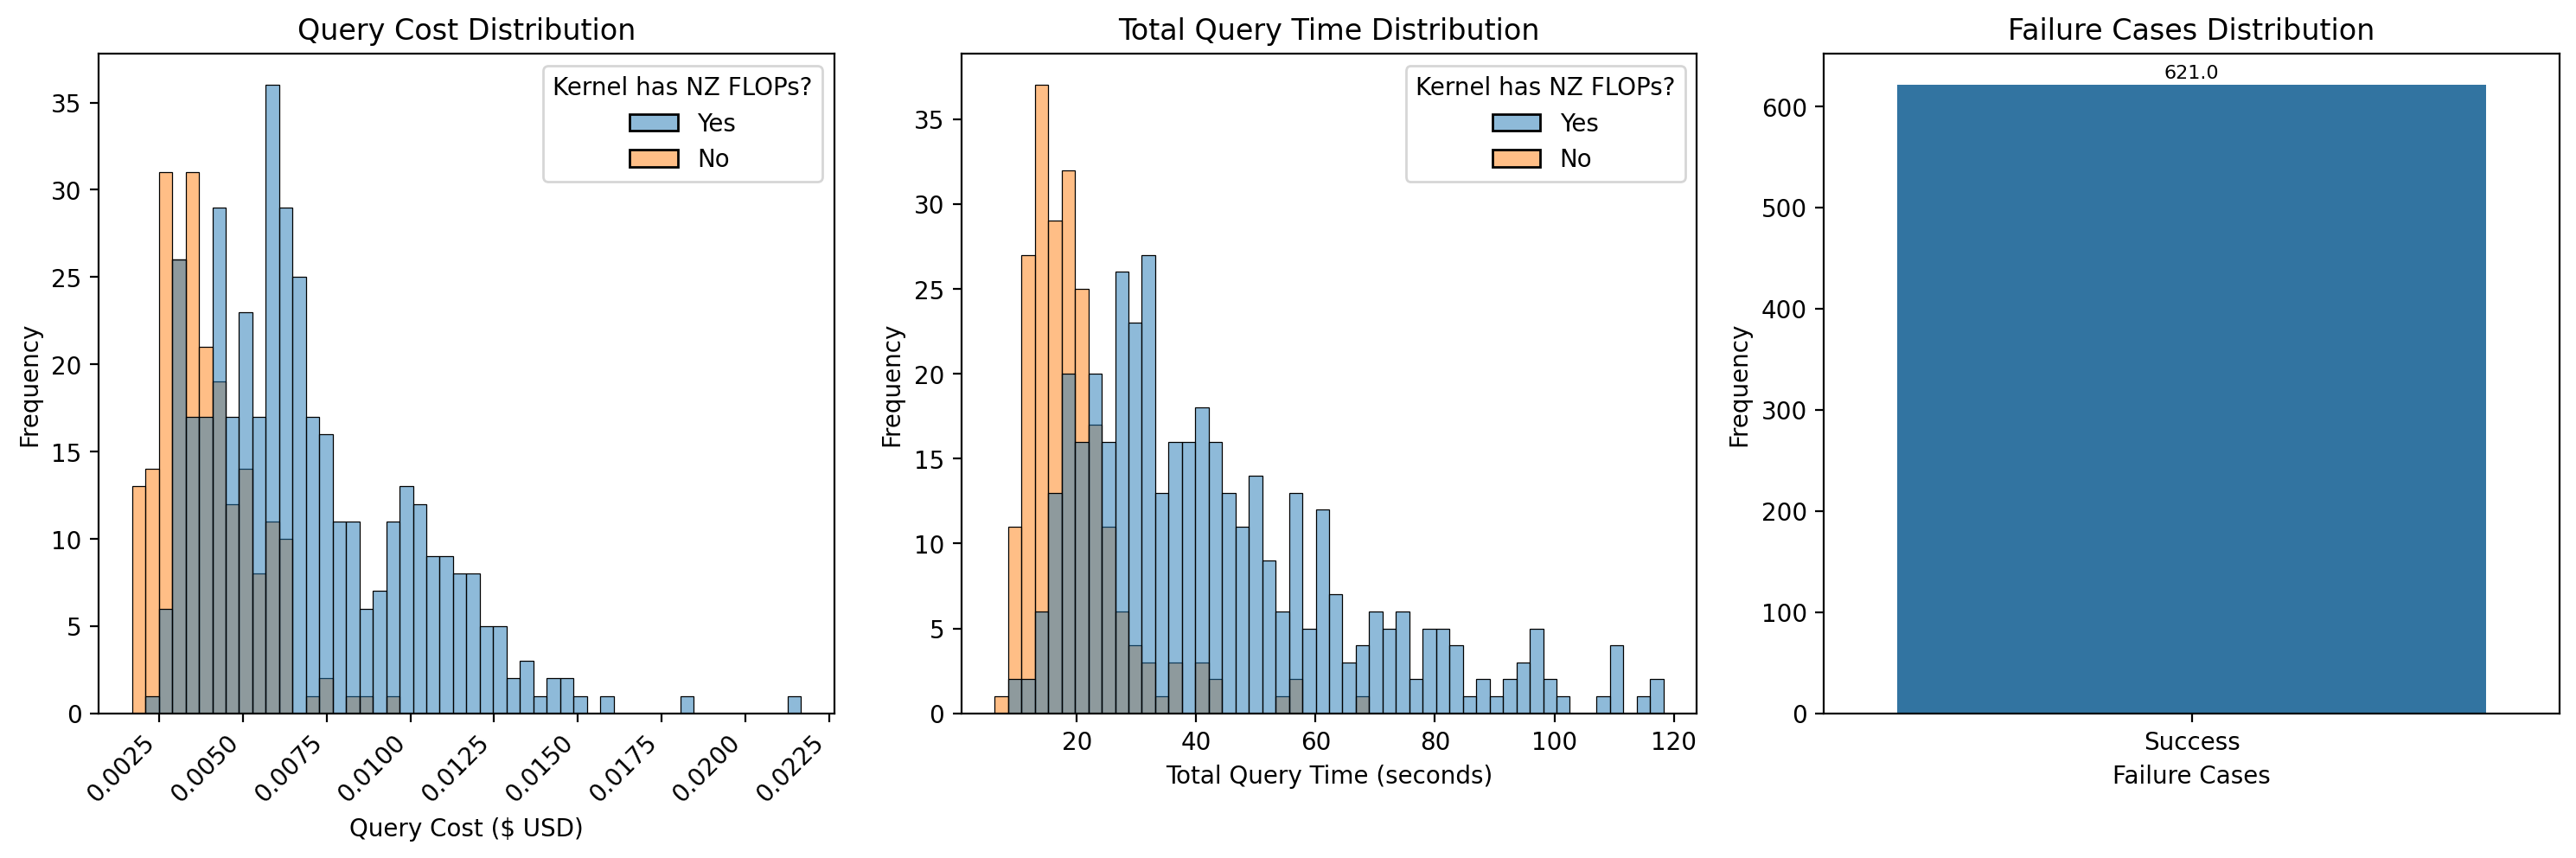

Success DF Size: (617, 32)


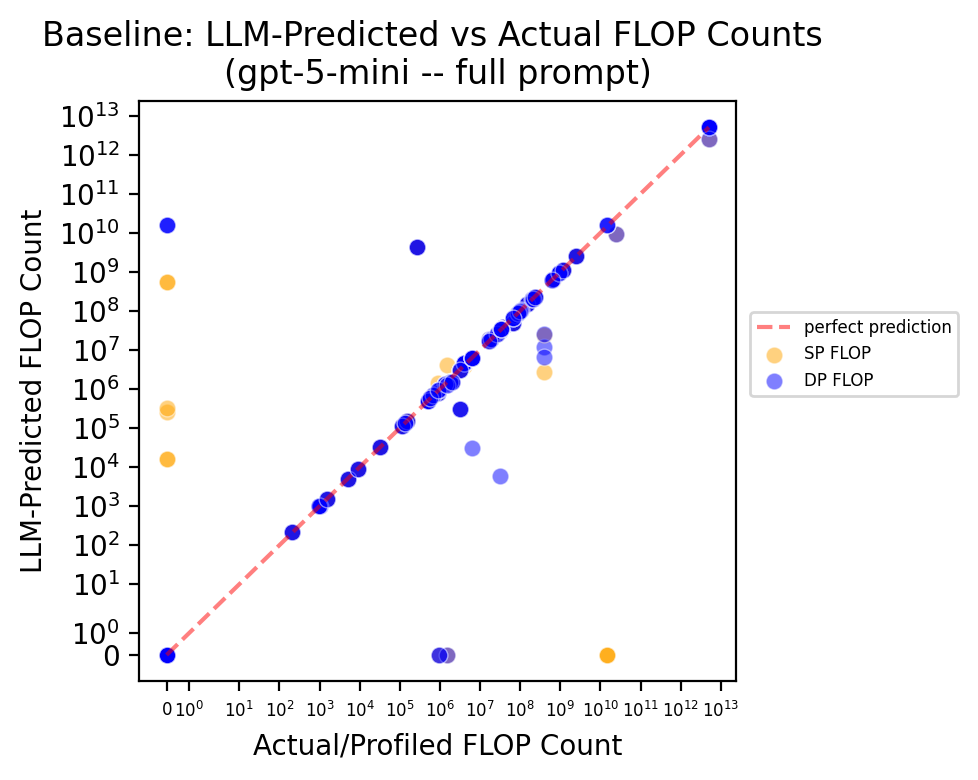

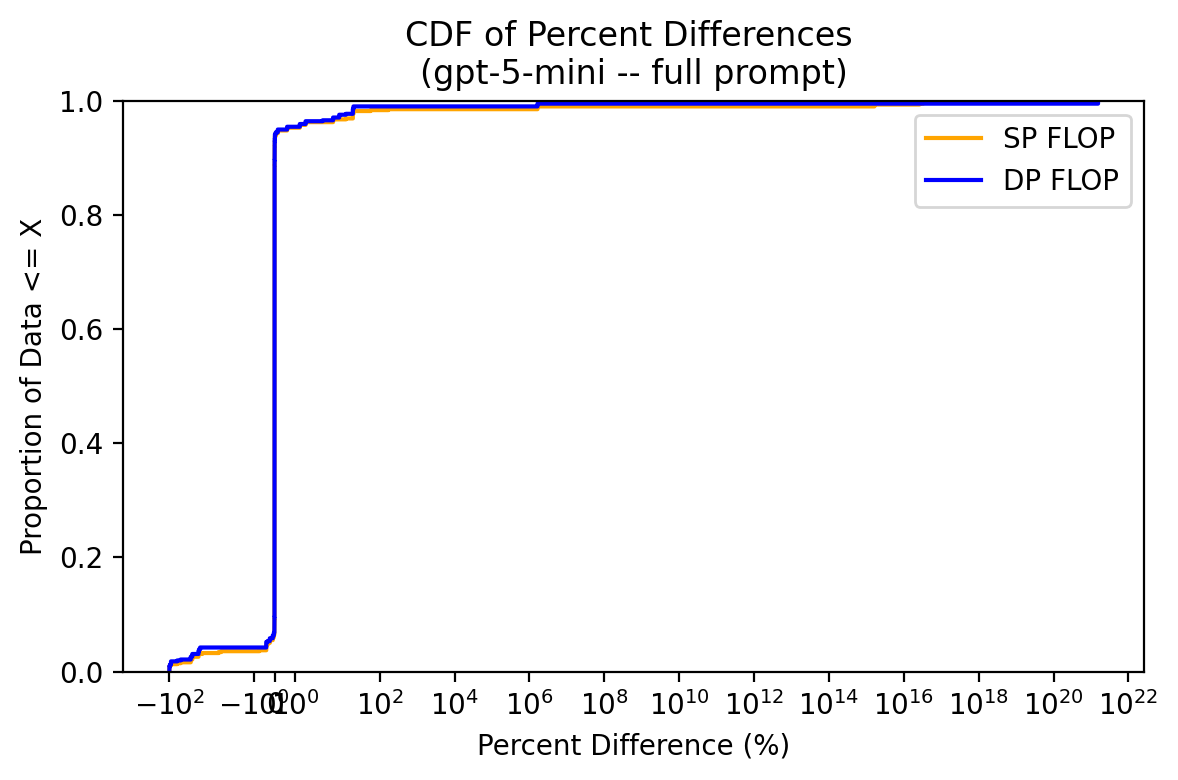

SP FLOP: 566 / 617 (91.73%) within +/- 1%
SP FLOP: 51 / 617 (8.27%) outside +/- 1%
DP FLOP: 563 / 617 (91.25%) within +/- 1%
DP FLOP: 54 / 617 (8.75%) outside +/- 1%


SP FLOP: 574 / 617 (93.03%) within +/- 5%
SP FLOP: 43 / 617 (6.97%) outside +/- 5%
DP FLOP: 570 / 617 (92.38%) within +/- 5%
DP FLOP: 47 / 617 (7.62%) outside +/- 5%


SP FLOP: 577 / 617 (93.52%) within +/- 10%
SP FLOP: 40 / 617 (6.48%) outside +/- 10%
DP FLOP: 576 / 617 (93.35%) within +/- 10%
DP FLOP: 41 / 617 (6.65%) outside +/- 10%


SP FLOP: 597 / 617 (96.76%) within +/- 50%
SP FLOP: 20 / 617 (3.24%) outside +/- 50%
DP FLOP: 599 / 617 (97.08%) within +/- 50%
DP FLOP: 18 / 617 (2.92%) outside +/- 50%


SP FLOP: 604 / 617 (97.89%) within +/- 100%
SP FLOP: 13 / 617 (2.11%) outside +/- 100%
DP FLOP: 611 / 617 (99.03%) within +/- 100%
DP FLOP: 6 / 617 (0.97%) outside +/- 100%




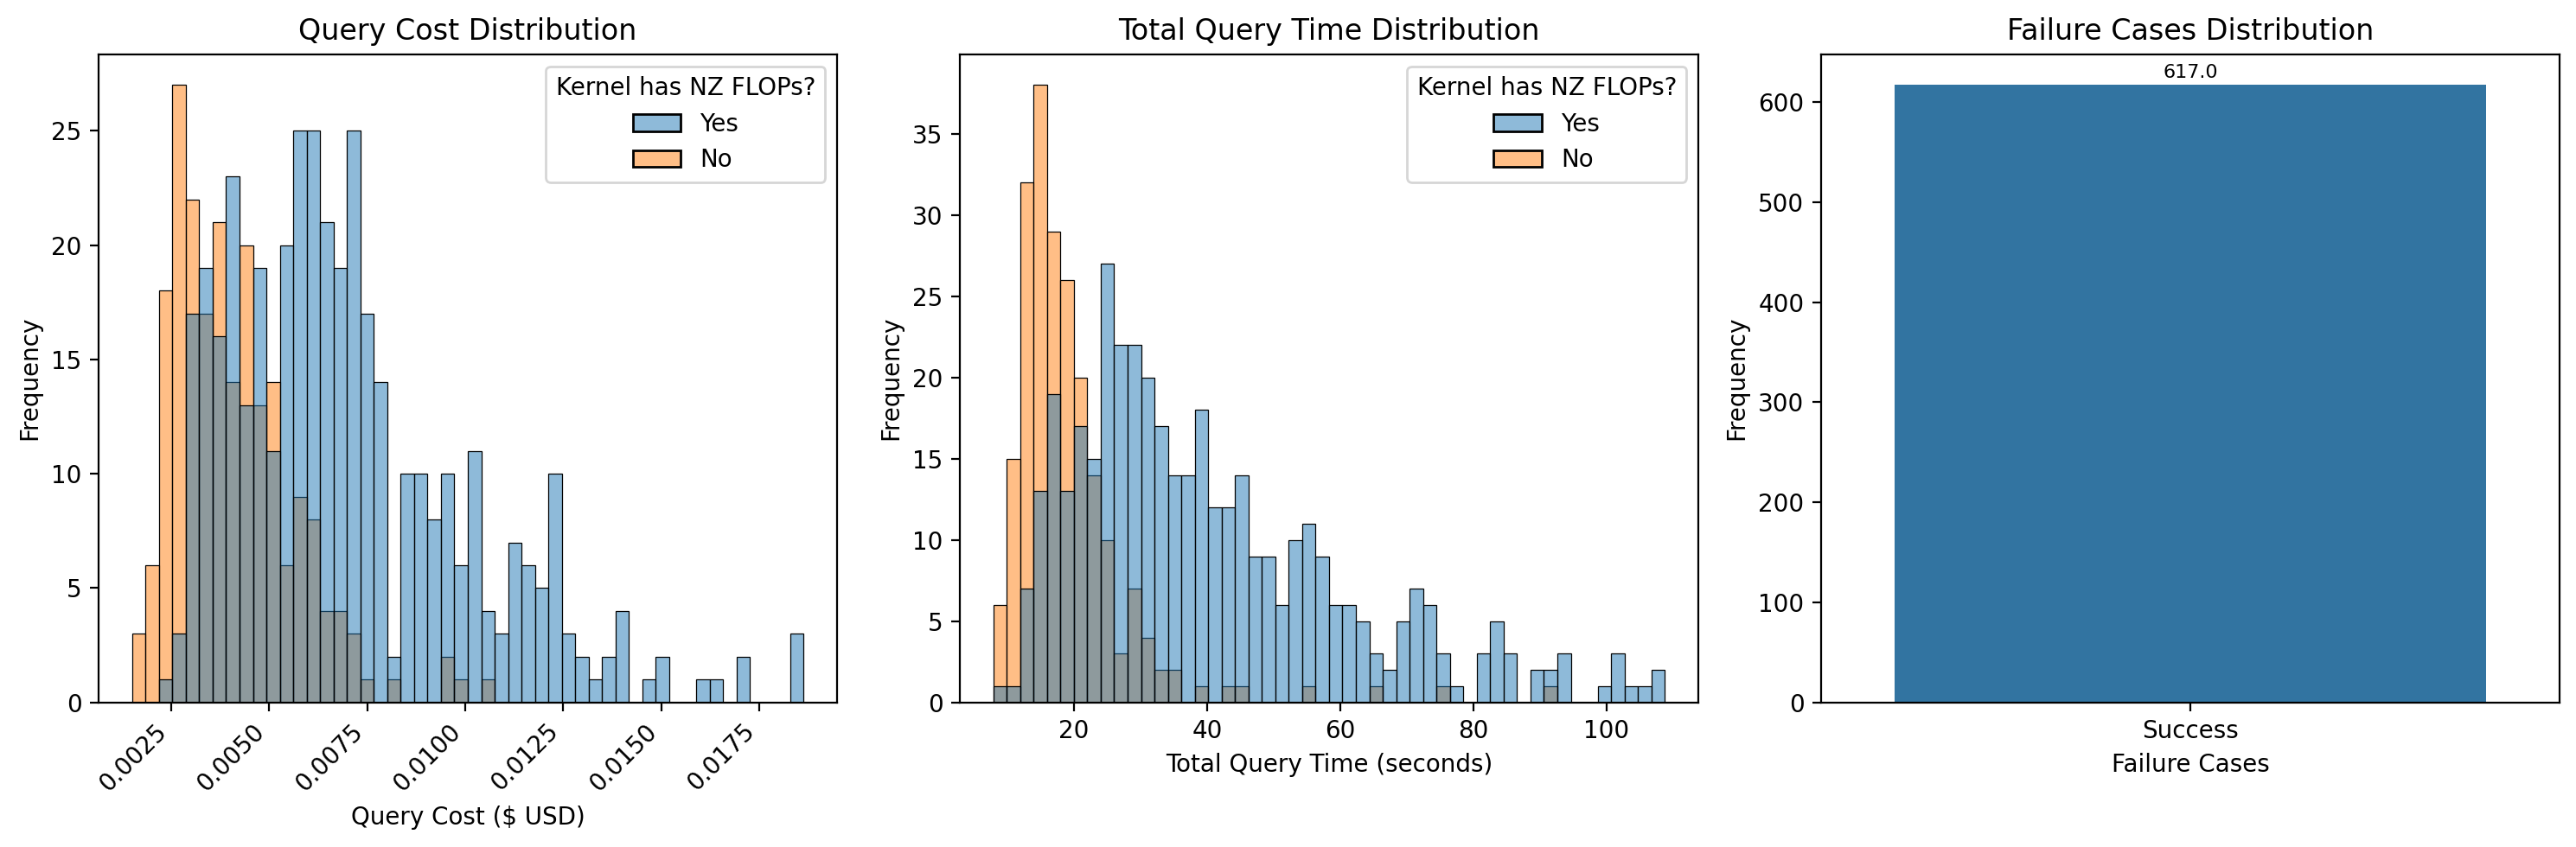

In [17]:
plot_predictions_for_model_name(df, 'gpt-5-mini', 'simple')
plot_predictions_for_model_name(df, 'gpt-5-mini', 'full')